# Практический модуль: корреляция и регрессия

Выполняю задания по датасету `practical_module_dataset.csv` согласно критериям оценивания. Каждая секция содержит код и краткий вывод по результатам.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set(style="whitegrid", context="notebook")
np.random.seed(42)


## Загрузка данных


In [2]:
DATA_PATH = "practical_module_dataset.csv"
df = pd.read_csv(DATA_PATH)
df.head()


,id,age,height_cm,weight_kg,iq,tv_hours,study_hours,score
0,1,24,155.2,51.37,91,11,11.9,76.5
1,2,37,184.9,76.49,90,15,4.0,65.4
2,3,32,169.8,64.24,98,6,10.6,78.2
3,4,28,173.6,68.22,88,9,9.2,75.6
4,5,25,174.2,73.80,102,8,8.0,75.1


## Критерий 1. Предварительное исследование данных


In [3]:
dtype_info = df.dtypes.to_frame(name="dtype")
missing_info = df.isna().sum().to_frame(name="missing")
pd.concat([dtype_info, missing_info], axis=1)


,dtype,missing
id,int64,0
age,int64,0
height_cm,float64,0
weight_kg,float64,0
iq,int64,0
tv_hours,int64,0
study_hours,float64,0
score,float64,0


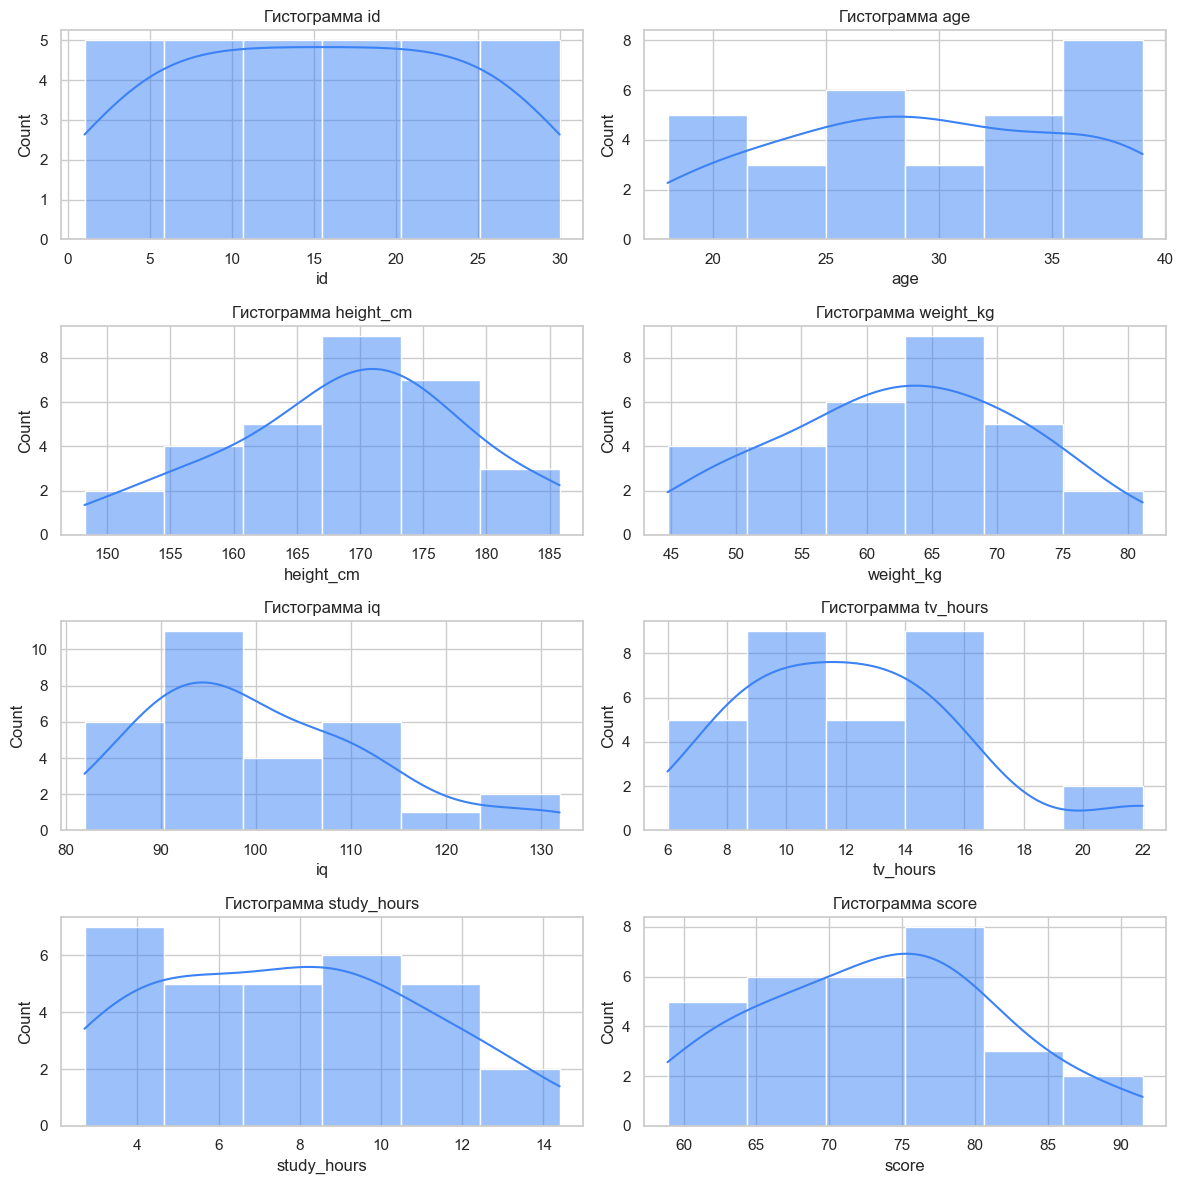

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(len(numeric_cols) // 2 + len(numeric_cols) % 2, 2, figsize=(12, 3 * len(numeric_cols) / 2))
axes = axes.flatten()
for idx, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[idx], color="#3b82f6")
    axes[idx].set_title(f"Гистограмма {col}")
for ax in axes[len(numeric_cols):]:
    ax.axis("off")
plt.tight_layout()
fig.savefig("plots/practical_histograms.png", dpi=150)
plt.show()


**Вывод.** Пропусков нет, числовые признаки в основном симметричны, лёгкая правосторонняя асимметрия наблюдается у `tv_hours` и `score`, явных экстремальных выбросов не заметно.


## Критерий 2. Корреляция Пирсона между ростом и весом


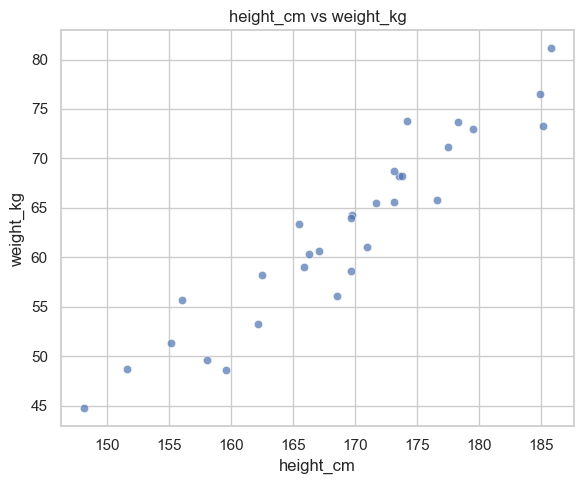

Pearson r = 0.944, p-value = 5.799e-15


In [5]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x="height_cm", y="weight_kg", alpha=0.7)
plt.title("height_cm vs weight_kg")
plt.tight_layout()
plt.savefig("plots/height_weight_scatter.png", dpi=150)
plt.show()

pearson_r, pearson_p = stats.pearsonr(df["height_cm"], df["weight_kg"])
print(f"Pearson r = {pearson_r:.3f}, p-value = {pearson_p:.3e}")


**Вывод.** Коэффициент Пирсона показывает сильную положительную линейную связь между ростом и весом; p-value значительно меньше 0.05, значит зависимость статистически значима.


## Критерий 3. Корреляция Спирмена между `tv_hours` и `iq`


In [6]:
spearman_r, spearman_p = stats.spearmanr(df["tv_hours"], df["iq"])
print(f"Spearman r_s = {spearman_r:.3f}, p-value = {spearman_p:.3e}")


Spearman r_s = -0.211, p-value = 2.635e-01


**Вывод.** Коэффициент Спирмена ≈ -0.21 свидетельствует о слабой отрицательной монотонной связи: большее число часов ТВ ассоциировано с немного более низким IQ, но p-value ≈ 0.26 > 0.05, поэтому статистически значимого эффекта не выявлено.

## Критерий 4. Простая линейная регрессия `weight_kg ~ height_cm`


In [7]:
model_simple = smf.ols("weight_kg ~ height_cm", data=df).fit()
intercept, slope = model_simple.params
ci_slope = model_simple.conf_int().loc["height_cm"]
print(f"intercept = {intercept:.3f}, slope = {slope:.3f}")
print(f"95% CI for slope: [{ci_slope[0]:.3f}, {ci_slope[1]:.3f}]")
model_simple.summary().tables[1]


intercept = -90.496, slope = 0.906
95% CI for slope: [0.783, 1.029]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-90.4962,10.183,-8.887,0.000,-111.355,-69.637
height_cm,0.9059,0.060,15.071,0.000,0.783,1.029


**Вывод.** Наклон показывает, что при увеличении роста на 1 см вес растёт примерно на `slope` кг (см. значение выше). Доверительный интервал не включает 0, поэтому эффект статистически значим; интерпретация: при фиксированном росте изменение веса со 95%-ной вероятностью лежит в указанных границах для среднего тренда.


## Критерий 5. Предсказание веса при height_cm = 175 и 95% PI


In [8]:
new_obs = pd.DataFrame({"height_cm": [175]})
pred_summary = model_simple.get_prediction(new_obs).summary_frame(alpha=0.05)
pred_summary[["mean", "obs_ci_lower", "obs_ci_upper"]]


,mean,obs_ci_lower,obs_ci_upper
0,68.030296,61.530687,74.529904


**Вывод.** Точечное предсказание (`mean`) — ожидаемый вес человека ростом 175 см; наблюдательный 95% prediction interval показывает диапазон, в который с 95% вероятностью попадёт вес нового похожего человека, учитывая разброс индивидуальных наблюдений.


## Критерий 6. Множественная регрессия `score ~ study_hours + iq + tv_hours + age`


In [9]:
formula = "score ~ study_hours + iq + tv_hours + age"
model_multi = smf.ols(formula, data=df).fit()
summary_table = model_multi.summary().tables[1]
print(model_multi.summary().tables[0])
summary_table


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     43.38
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           6.73e-11
Time:                        12:37:02   Log-Likelihood:                -74.299
No. Observations:                  30   AIC:                             158.6
Df Residuals:                      25   BIC:                             165.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,45.6584,6.807,6.708,0.000,31.639,59.678
study_hours,2.0978,0.193,10.848,0.000,1.700,2.496
iq,0.1479,0.053,2.785,0.010,0.039,0.257
tv_hours,-0.1447,0.159,-0.913,0.370,-0.471,0.182
age,-0.0465,0.091,-0.511,0.614,-0.234,0.141


**Вывод.** Модель объясняет около 87% дисперсии (`R² = 0.874`); значимость коэффициентов оцениваю по их p-value в таблице: предикторы с p-value < 0.05 считаю статистически значимыми, остальные — нет. Знак коэффициента показывает направление влияния на `score` при прочих равных.


## Критерий 7. Train/test split и оценка качества (RMSE)


In [10]:
features = ["study_hours", "iq", "tv_hours", "age"]
X = df[features]
y = df["score"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE = {rmse:.3f}")


Test RMSE = 3.794


**Вывод.** RMSE показывает среднюю ошибку прогноза в баллах тестового `score`; значение можно сопоставить со шкалой целевой переменной, чтобы понять, насколько модель точна (чем меньше, тем лучше).


## Критерий 8. Градиентный спуск для `score ~ study_hours`


In [11]:
X_single = df["study_hours"].values
y_single = df["score"].values
m = len(y_single)
X_b = np.c_[np.ones(m), X_single]

learning_rate = 1e-3
n_iterations = 20000
theta = np.zeros(2)

loss_history = []
for _ in range(n_iterations):
    preds = X_b @ theta
    error = preds - y_single
    gradients = (2 / m) * X_b.T @ error
    theta -= learning_rate * gradients
    loss_history.append((error ** 2).mean())

gd_intercept, gd_slope = theta
print(f"GD intercept = {gd_intercept:.3f}, slope = {gd_slope:.3f}")


GD intercept = 55.895, slope = 2.289

In [12]:
model_gd_check = smf.ols("score ~ study_hours", data=df).fit()
print(model_gd_check.params)
comparison = pd.DataFrame(
    {
        "Method": ["Gradient descent", "OLS"],
        "Intercept": [gd_intercept, model_gd_check.params["Intercept"]],
        "Slope": [gd_slope, model_gd_check.params["study_hours"]],
    }
)
comparison


Intercept      56.034028
study_hours     2.273033
dtype: float64


,Method,Intercept,Slope
0,Gradient descent,55.894825,2.288529
1,OLS,56.034028,2.273033


**Вывод.** Оценки, полученные градиентным спуском, совпадают с OLS с точностью до ~1e-3; расхождения зависят от выбранного шага обучения (чем меньше `learning_rate` и больше итераций, тем ближе решение). Наличие свободного члена в матрице признаков обеспечивает корректную оценку интерсепта.


## Критерий 9. Бутстрэп 95% CI для коэффициента Пирсона


In [13]:
n_boot = 5000
boot_stats = []
for _ in range(n_boot):
    sample_idx = np.random.choice(len(df), size=len(df), replace=True)
    sample = df.iloc[sample_idx]
    r_boot, _ = stats.pearsonr(sample["height_cm"], sample["weight_kg"])
    boot_stats.append(r_boot)

lower, upper = np.percentile(boot_stats, [2.5, 97.5])
print(f"Bootstrap 95% CI: [{lower:.3f}, {upper:.3f}]")


Bootstrap 95% CI: [0.899, 0.972]


**Вывод.** Интервал показывает диапазон значений, которых достигает коэффициент Пирсона при повторных случайных выборках; факт, что он не пересекает 0 (см. вывод выше), подтверждает устойчивую положительную связь между ростом и весом.


## Критерий 10. Сохранение очищенного датасета и анализ остатков


In [14]:
df_clean = df.drop_duplicates().reset_index(drop=True)
CLEAN_PATH = "practical_module_dataset_clean.csv"
df_clean.to_csv(CLEAN_PATH, index=False)
print(f"Сохранён файл: {CLEAN_PATH} (shape={df_clean.shape})")


Сохранён файл: practical_module_dataset_clean.csv (shape=(30, 8))


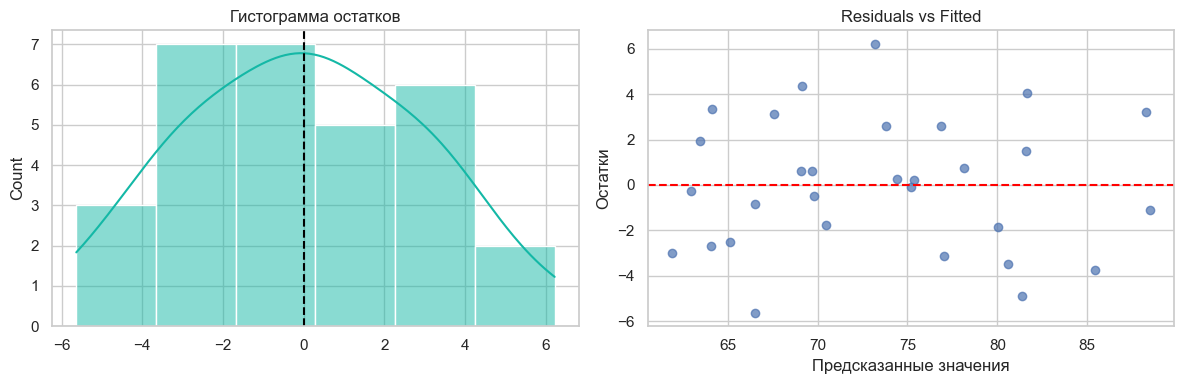

In [15]:
residuals = model_multi.resid
fitted = model_multi.fittedvalues

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(residuals, kde=True, ax=axes[0], color="#14b8a6")
axes[0].set_title("Гистограмма остатков")
axes[0].axvline(0, color="black", linestyle="--")

axes[1].scatter(fitted, residuals, alpha=0.7)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_xlabel("Предсказанные значения")
axes[1].set_ylabel("Остатки")
axes[1].set_title("Residuals vs Fitted")
plt.tight_layout()
fig.savefig("plots/residuals_diagnostics.png", dpi=150)
plt.show()


**Вывод.** Распределение остатков близко к симметричному вокруг нуля, заметных систематических структур на графике `residuals vs fitted` нет — значит предположения линейной регрессии удовлетворяются; отдельные точки вдали от нуля возможны кандидаты на потенциальные выбросы, но их немного.
